# Ensembled Temperature Predictor

In [1]:
import gc
import pickle
from typing import Iterable

import gsod
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

gsod.enable_svg_graphing()
gsod.suppress_tf_log()

Init Plugin
Init Graph Optimizer
Init Kernel


In [2]:
STATION = "722860"
ds = gsod.GsodDataset("runtime/GSOD")
filled = ds.read_continuous(stn=STATION, year="????", fill="ffill")
filled.describe().T

imfs_array = np.load("runtime/imfs.npy")
imfs = pd.DataFrame(imfs_array.T,
                    columns=[f"IMF_{n+1}" for n in range(len(imfs_array))])
imfs.index = filled.index
imfs.describe().T

,count,mean,std,min,25%,50%,75%,max
IMF_1,32385.0,-0.010341,1.448780,-7.619775,-0.938657,-0.025685,0.899248,7.339371
IMF_2,32385.0,-0.000769,0.229555,-1.873865,-0.148163,-0.002532,0.145699,2.381269
IMF_3,32385.0,-0.002342,1.173247,-6.153759,-0.737930,-0.009505,0.718905,5.660010
IMF_4,32385.0,-0.007225,1.720509,-9.036885,-1.152501,-0.018415,1.136218,9.461683
IMF_5,32385.0,-0.008126,1.716780,-7.370834,-1.199286,-0.027894,1.172238,6.879642
IMF_6,32385.0,-0.006295,1.587482,-5.899611,-1.146065,0.001791,1.115562,6.086489
IMF_7,32385.0,-0.003402,1.457385,-4.969838,-1.034858,-0.007800,1.053806,5.542054
IMF_8,32385.0,0.003878,1.177733,-4.540745,-0.800170,-0.010096,0.822102,5.078037
IMF_9,32385.0,-0.631664,6.886718,-13.717210,-6.493557,-1.907737,5.688205,14.087583
IMF_10,32385.0,-0.025981,2.868308,-7.265178,-2.248982,-0.039295,2.231048,6.651529


Load pre-trained models from disk.

## LSTM and MLP
LSTM handles the high-frequency periods and MLP handles the rest.

In [3]:
import json

def get_models():
    """Automatically select a model based on test MAE."""
    mlp_performace = json.load(open("runtime/mlp_perf.json"))["test"]
    lstm_performace = json.load(open("runtime/lstm_perf.json"))["test"]
    # Skip the last IMF (the trend term)
    for i in range(len(imfs.T) - 1):
        name = f"IMF_{i + 1}"
        if mlp_performace[name][1] < lstm_performace[name][1]:
            print(f"Selecting MLP for {name}")
            yield tf.keras.models.load_model(f"runtime/MLP_{name}.h5")
        else:
            print(f"Selecting LSTM for {name}")
            yield tf.keras.models.load_model(f"runtime/LSTM_{name}.h5")

Prediction helper for the models.

In [4]:
def predict_temperature(
    prev_imfs,
    models: Iterable[tf.keras.Model]
) -> float:
    """Predict a single temperature from a window.
    
    Parameters
    ----------
        prev_imfs: (n_imfs, window_width) IMFs.
        models: List of models for each imf.
        
    Returns
    -------
    float
        Prediction.
    """
    result = 0.0
    for imf, model in zip(prev_imfs, models):
        model_input = imf.reshape(1, -1, 1)
        result += model(model_input)[0, -1, 0]
    return result

def batch_predict_temperature(
    imfs,
    models: Iterable[tf.keras.Model],
    *,
    window_width: int = 7,
    n_predictions: int = -1
):
    """Predict a single temperature from a window.
    
    Parameters
    ----------
        imfs: (n_imfs, n_predictions + window_width - 1) IMFs for predictions.
              If the length of the second dimension is larger, the extra ones
              at the front will be ignored.
        models: List of models for each imf.
        window_width: width of the window.
        n_predictions: number of predictions to make. Default of -1 for all.
        
    Returns
    -------
    NDArray[float]
        Predictions.
    """
    # Reset n_predictions for all
    if n_predictions < 0:
        n_predictions = imfs.shape[1] + 1 - window_width
    # Pre-allocate array
    result = np.zeros(n_predictions)
    for imf, model in zip(imfs, models):
        imf_to_use = imf[-(n_predictions + window_width - 1):]
        window = gsod.sliding_window(imf_to_use, window_width)
        # Add each IMF's result to the prediction
        result += model.predict(
            window.reshape(-1, window_width, 1)
        # window_width - shift
        )[:, window_width - 1, 0]
        tf.keras.backend.clear_session()
        gc.collect()
    return result

In [5]:
with tf.device("/cpu:0"):
    result = batch_predict_temperature(np.asarray(imfs.T)[:-1], get_models())

Metal device set to: Apple M1
Selecting LSTM for IMF_1
Selecting LSTM for IMF_2
Selecting LSTM for IMF_3
Selecting LSTM for IMF_4
Selecting LSTM for IMF_5
Selecting LSTM for IMF_6
Selecting LSTM for IMF_7
Selecting LSTM for IMF_8
Selecting LSTM for IMF_9
Selecting LSTM for IMF_10
Selecting LSTM for IMF_11
Selecting LSTM for IMF_12
Selecting LSTM for IMF_13


## Linear Regression Handles the Trend

In [6]:
lr_last_imf = pickle.load(open("runtime/last_imf_linear.pkl", "rb"))

last_imfs_windows = gsod.sliding_window(imfs[imfs.columns[-1]], 7)
last_imf = lr_last_imf.predict(last_imfs_windows)

## Finally Combine the results

In [7]:
# The last temperature is the future, so skip its calculation
prediction = result[:-1] + last_imf[:-1]
actual = np.asarray(filled["TEMP"])[7:]
indices = filled.index[7:]

Text(0, -50, 'MAE: 0.7212${}^\\circ$F\nRMSE: 0.9414${}^\\circ$F')

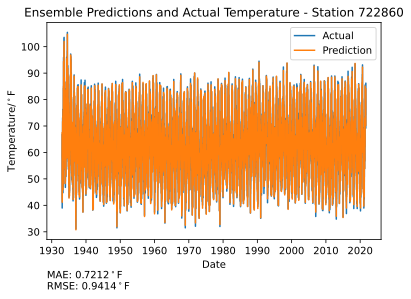

In [8]:
plt.plot(indices, actual, label="Actual")
plt.plot(indices, prediction, label="Prediction")
plt.legend()
plt.title(f"Ensemble Predictions and Actual Temperature - Station {STATION}")
plt.xlabel("Date")
plt.ylabel("Temperature/${}^\circ$F")
plt.annotate(
    f"MAE: {np.average(np.abs(prediction - actual)):0.4}${{}}^\circ$F\n"
    + f"RMSE: {np.average((prediction - actual)**2)**0.5:0.4}${{}}^\circ$F",
    (0, -50),
    xycoords="axes points"
)

Text(0, -50, 'MAE: 0.6446${}^\\circ$F\nRMSE: 0.8442${}^\\circ$F')

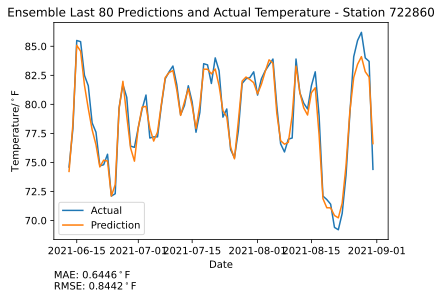

In [9]:
plt.plot(indices[-80:], actual[-80:], label="Actual")
plt.plot(indices[-80:], prediction[-80:], label="Prediction")
plt.legend()
plt.title(f"Ensemble Last 80 Predictions and Actual Temperature - Station {STATION}")
plt.xlabel("Date")
plt.ylabel("Temperature/${}^\circ$F")
plt.annotate(
    f"MAE: {np.average(np.abs(prediction[-80:] - actual[-80:])):0.4}${{}}^\circ$F\n"
    + f"RMSE: {np.average((prediction[-80:] - actual[-80:])**2)**0.5:0.4}${{}}^\circ$F",
    (0, -50),
    xycoords="axes points"
)